<p style="text-align: center">
<img src="../../assets/images/dtlogo.png" alt="Duckietown" width="50%">
</p>

# 💻 04 - Image filtering

Images contain a tremendous amount of data. A $640 \times 480$ grayscale image contains 307,200 pixels, each of which can take on one of 256 different values. Reasoning over raw images as a means of estimating the structure of a robot's environment is intractable, particularly when we want to process images in real-time as they are streamed at 30 frames-per-second from a robot's camera.

<figure>
  <div style="text-align:center;">
  <img src="../../assets/images/image_filtering/image-filtering-block-diagram.png" width="400px" />
  <p>Image filtering performs local operations on an image using a kernel matrix as a means of enhancing its content.</p>
  </div>
</figure>

Image filtering provides a means of enhancing an image by amplifying certain desireable aspects of the image while supressing others. The result is a transformation of the original raw image into a more concise collection of salient information.

<figure>
  <div style="text-align:center;">
  <img src="../../assets/images/image_filtering/image-filtering-local-window.png" width="400px" />
  <p>Image filtering performs local operations on an image using a kernel matrix as a means of enhancing its content.</p>
  </div>
</figure>

In image filtering, each pixel in the output image is computed from a weighted combination of the neighboring pixels in the input image. This weighting is is referred to as the *filter kernel* and takes the form of a small (relative to the image) matrix $h$. Importantly, the kernel is the same everywhere in the image. 

Mathematically, we can represent image filtering as the process of convolving the image with the kernel filter

$$Y = I*h$$

which, for each pixel $u,v$ in the output image becomes

$$Y[u,v] = \sum_{k,l} h[k,l]I[u-k,v-l]$$

Notice that the $I[u-k,v-l]$ inside the sum has the effect of flipping the kernel $h$ left-to-right and top-to-bottom.

The kernel determines which content is amplified and which is supressed, and so we design the kernel based upon how we want to enhance the image.

### Example: Image blurring

In this example, we are given a noisy image and want to design a filter that removes as much of the noise as possible, while not losing too much of the actual detail. A candidate for such a filter is the *box filter*, a normalized matrix of ones.

$$ h = \frac{1}{N} 
\begin{bmatrix}
1 & 1 & \cdots & 1\\
1 & 1 & \cdots & 1\\
\vdots & \vdots & \ddots & \vdots\\
1 & 1 & \cdots & 1
\end{bmatrix}
$$

where $N$ is the number of elements in the matrix. In designing a box filter, we have freedom to decide on the width and height of the kernel, though we will assume that the matrix is square. Increasing the size of the kernel means that a greater number of neighboring pixels will be used in determining the average intensity at each output location. Intuitively, this will improve noise reduction at the expense of attenuating actual detail in the image.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
### Run this cell to import relevant modules
from matplotlib import pyplot as plt
import numpy as np
import cv2

Image size:  (607, 910)


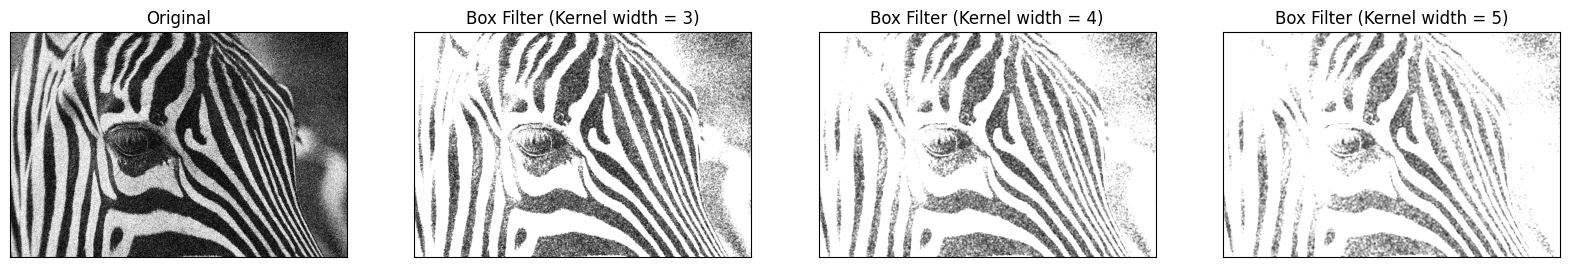

In [17]:
# TODO: Create a 3x3 box filter and compare the result of convolving the noisy image above with larger box filters.
#       Can you find the filter width above which too much detail is lost?

# load the image
img = cv2.imread('../../assets/images/image_filtering/zebra-noisy.jpg', 0)
print("Image size: ",img.shape)

# Visualize the filtered image alongside the original image.
N = 3
fig = plt.figure(figsize = (20,12))
ax = fig.add_subplot(1,N+1,1)
ax.imshow(img,cmap = 'gray')
ax.set_title('Original'), ax.set_xticks([]), ax.set_yticks([])
for i in range(N):
    width = 3+i
    hbox = np.ones((width,width), dtype=np.float32)
    hbox /= sum(hbox)
    img_box_filter = cv2.filter2D(img,-1,hbox)
    ax = fig.add_subplot(1,N+1,i+2)
    ax.imshow(img_box_filter,cmap = 'gray')
    ax.set_title('Box Filter (Kernel width = ' + str(width) +')'), ax.set_xticks([]), ax.set_yticks([]);

## Gaussian Blurring

While the box filter is intuitive, using it to smooth an image prior to computing numerical derivatives can result in artefacts. <br>
In practice, people commonly use a kernel that approximates a zero-mean (i.e., centered at the origin) isotropic (i.e., cross-sections are circles; the distribution spreads out evenly in all directions) Gaussian

$$ G_\sigma = \frac{1}{2 \pi \sigma^2} e^{-\frac{x^2+y^2}{2\sigma^2}} $$

where $\sigma$ is the standard deviation. The advantage of using a Gaussian kernel over a box filter is that it places more weight on nearby neighbors than it does on those that are farther away.

<figure>
  <div style="text-align:center;">
  <img src="../../assets/images/image_filtering/gaussian-kernel.png" width="400px" />
  <p>A 2D Gaussian (left) and a Gaussian kernel (right).</p>
  </div>
</figure>

The standard deviation $\sigma$ determines how quickly the Gaussian decays. <br>
For large values of $\sigma$, the Gaussian will decay slowly and, in turn, neighboring pixels will be weighed similarly. <br>
On the other hand, small values for $\sigma$ result in a more peaked distribution, with the weights dropping off quickly.

While Gaussians have infinite support, we are interested in kernels that are finite (and typically small). <br>
We will typically choose the size of the kernel based on the support of the distribution (i.e., how spread out it is), which is determined by the standard deviation. <br>

When the standard deviation is small and the distribution is peaked, we can use a small kernel since weights outside the kernel will be very small. <br>
However, when the standard deviation is larger and the distribution is more spread out, we tend to use a larger kernel.

### Example: Gaussian blurring

The Gaussian kernel is defined by its size and standard deviation $\sigma$. <br>
Since the standard deviation determines the rate at which the weights of the kernel decay, it is common to choose the size of the kernel (which will be square for isotropic Gaussians) based upon the standard deviation. Many existing libraries, including the implementation in OpenCV, support this functionality.

In this exercise, you will experiment with different choices of the standard deviation and compare them to the result of using the box filter that you identified above. 

Try and find a setting for the standard deviation that reduces noise without removing too much content from the image.

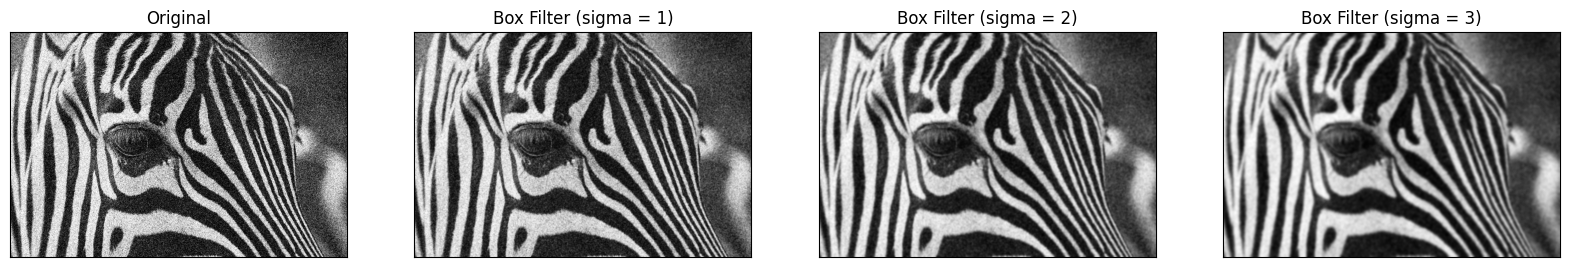

In [11]:
# TODO: Experiment with different settings for the standard deviation of the Gaussian and compare the results to a box filter.
#.      Identify a setting for the standard deviation that removes noise while not eliminating too much valid content.

N = 3
fig = plt.figure(figsize = (20,12))
ax = fig.add_subplot(1,N+1,1)
ax.imshow(img,cmap = 'gray')
ax.set_title('Original'), ax.set_xticks([]), ax.set_yticks([])
for i in range(N):
    sigma = 1+i
    img_gaussian_filter = cv2.GaussianBlur(img,(0,0), sigma)
    ax = fig.add_subplot(1,N+1,i+2)
    ax.imshow(img_gaussian_filter,cmap = 'gray')
    ax.set_title('Box Filter (sigma = ' + str(sigma<br><) +')'), ax.set_xticks([]), ax.set_yticks([]);

## Enhancing Edges
Edges are a feature of an image that are used for a variety of tasks, including segmentation, object detection, shape estimation, and scene reconstruction. <br>
In the case of Duckietown and other self-driving domains, access to edge information is also very useful for detecting lane boundaries.

<figure>
  <div style="text-align:center;">
  <img src="../../assets/images/image_filtering/1d-intensity-change.png" width="700px" />
  <p>The change in intensity associated with an edge where an image transitions from white to black and black to white.</p>
  </div>
</figure>

Edges correspond to significant changes in local intensity. <br>
This suggests that we can identify edges by looking for regions in the image where the **intensity gradient $\nabla I$ is large**. <br>
Consider the left-most image above, which might be a zoomed in view of one of the zebra's vertical stripes. <br>
Moving left-to-right along a single row of the image, we see that the intensity rapidly drops as the pixels transition from being white (i.e., close to 255) to black (i.e., closs to 0), and then stay small until they jump back up as the pixels go from black to white. <br>
The edges are clearly visible as spikes in the $x$-component of the intensity gradient.

In general, we are interested in the two-dimensional image gradient, which includes both horizontal as well as vertical changes in intensity:

$$ \nabla I[u,v] = 
\begin{bmatrix}
\frac{\partial I[u,v]}{\partial x}\\
\frac{\partial I[u,v]}{\partial y}
\end{bmatrix}
$$

The **magnitude of the gradient** $\lvert \nabla I[u,v] \rvert$ provides a measure of the strength of the edge, while it points in the direction of greatest change

$$ 
\lvert \nabla I[u,v] \rvert = \sqrt{\left(\frac{\partial I[u,v]}{\partial x}\right)^2 + \left(\frac{\partial I[u,v]}{\partial y}\right)^2} \qquad
\theta[u,v] = \textrm{atan2}\left(\frac{\partial I[u,v]}{\partial y}, \frac{\partial I[u,v]}{\partial x}\right)
$$

Since pixels are discrete, we can't compute the derivatives analytically. <br>
Instead, we estimate them numerically via a finite difference approximation. <br>
We can compute these estimates by convolving the image with appropriately chosen kernels $h_x$ and $h_y$ that compute finite derivatives in the $x$ and $y$ directions, respectively:

$$ \nabla I[u,v] = 
\begin{bmatrix}
G_x[u,v]\\
G_y[u,v]
\end{bmatrix}
$$

where

$$ 
\begin{align}
G_x = h_x * I\\
G_y = h_y * I
\end{align}
$$

### Example: Image gradients

In this example, you will design different filter kernels, $h_x$ and $h_y$, to estimate the horizontal and vertical gradients of an image. In doing so, remember that the filter will be flipped left-to-right and top-to-bottom when performing convolution.

In [46]:
def plot_images_gradients(hx):

    # Get same kernel in vertical direction
    hy = np.array(hx, dtype=np.float32).transpose()
    
    # Read image and convolve with a Gaussian to remove noise
    img = cv2.imread('../../assets/images/image_filtering/zebra-noisy.jpg', 0)
    sigma = 2
    img_gaussian_filter = cv2.GaussianBlur(img,(0,0), sigma)

    # Apply the filters to the blurred image
    Gx = cv2.filter2D(img_gaussian_filter.astype(np.float32),-1,hx)
    Gy = cv2.filter2D(img_gaussian_filter.astype(np.float32),-1,hy)

    # Compute the magnitude of the gradients
    Gmag = np.sqrt(Gx*Gx + Gy*Gy)

    # Visualize the filtered image alongside the original image.
    fig = plt.figure(figsize = (20,20))
    ax1 = fig.add_subplot(1,4,1)
    ax1.imshow(img,cmap = 'gray')
    ax1.set_title('Blurred Image'), ax1.set_xticks([]), ax1.set_yticks([])

    ax2 = fig.add_subplot(1,4,2)
    ax2.imshow(Gx,cmap = 'gray')
    ax2.set_title('Horizontal Gradients'), ax2.set_xticks([]), ax2.set_yticks([]);

    ax3 = fig.add_subplot(1,4,3)
    ax3.imshow(Gy,cmap = 'gray')
    ax3.set_title('Vertical Gradients'), ax3.set_xticks([]), ax3.set_yticks([]);
    
    ax4 = fig.add_subplot(1,4,4)
    ax4.imshow(np.uint8(Gmag),cmap = 'gray')
    ax4.set_title('Gradient Magnitude'), ax4.set_xticks([]), ax4.set_yticks([]);

    print ("Max gradient: ", np.max(Gmag))

[[-1.  0.  1.]]
Max gradient:  77.665955


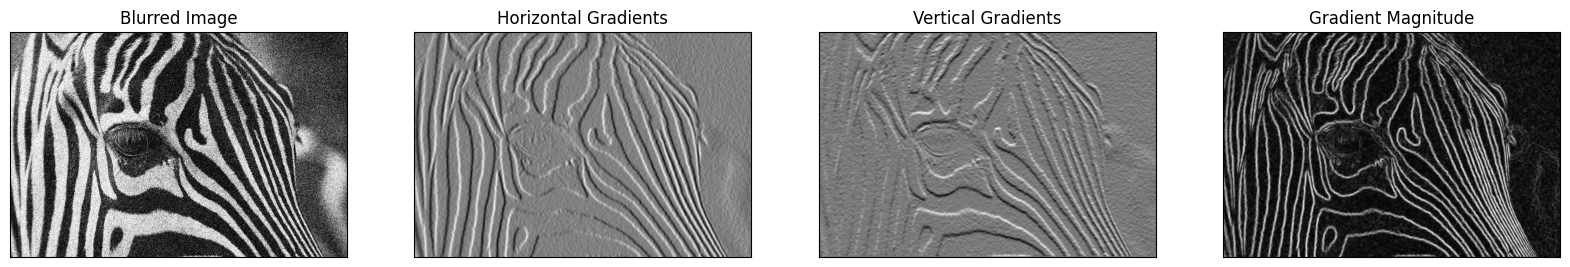

In [47]:
# TODO: Design two kernels hx and hy to estimate the horizontal and vertical gradients of an image
#       These filters will be applied to the blurred image that you generated above. As you experiment with different
#       kernels, compare the output for different amounts of blurring (i.e., different standard deviations). In particular, 
#       compare the gradients and their magnitude with little (i.e., sigma=1) or no blurring to an image blurred with a large kernel

hx = np.array([[-1, 0, 1]], dtype=np.float32)
print(hx)
plot_images_gradients(hx)

Max gradient:  776.6595


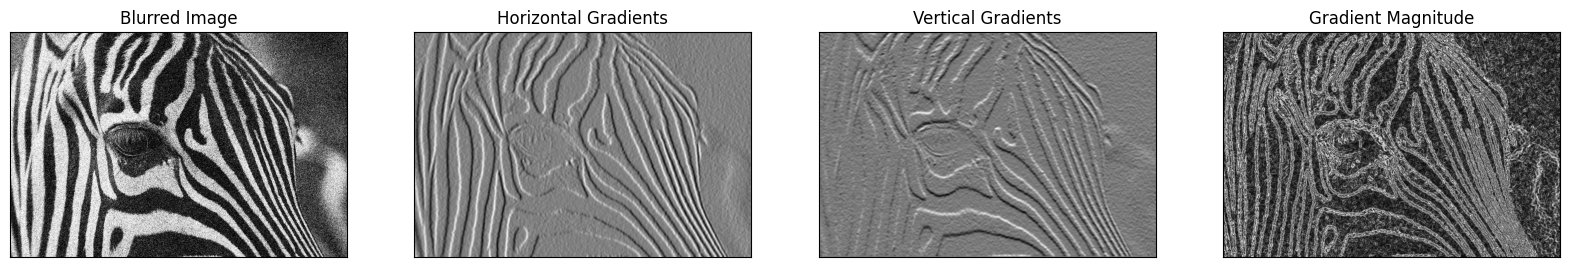

In [48]:
# TODO: Design two kernels hx and hy to estimate the horizontal and vertical gradients of an image
#       These filters will be applied to the blurred image that you generated above. As you experiment with different
#       kernels, compare the output for different amounts of blurring (i.e., different standard deviations). In particular, 
#       compare the gradients and their magnitude with little (i.e., sigma=1) or no blurring to an image blurred with a large kernel

# Kernels hx and hy to estimate the horizontal and vertical gradients of an image
hx = np.array([[-10, 0, 10]], dtype=np.float32)
plot_images_gradients (hx)

### Sobel Operator
A popular set of kernels used the emphasize edges in an image is the *Sobel operator*, which consists of two $3 \times 3$ kernels:

$$ h_x = 
\begin{bmatrix}
+1 & 0 & -1\\
+2 & 0 & -2\\
+1 & 0 & -1
\end{bmatrix}\qquad
h_y = 
\begin{bmatrix}
+1 & +2 & +1\\
0 & 0 & 0\\
-1 & -2 & -1
\end{bmatrix}
$$

These kernels correspond to simple averaging-based blurring followed by a simple finite derivative:

$$ h_x = 
\begin{bmatrix}
+1 & 0 & -1\\
+2 & 0 & -2\\
+1 & 0 & -1
\end{bmatrix} = 
\begin{bmatrix}
1\\
2\\
1
\end{bmatrix} * 
\begin{bmatrix}
+1 & 0 & -1\\
\end{bmatrix} \qquad
h_y = 
\begin{bmatrix}
+1 & +2 & +1\\
0 & 0 & 0\\
-1 & -2 & -1
\end{bmatrix} = 
\begin{bmatrix}
+1\\
0\\
-1
\end{bmatrix} * 
\begin{bmatrix}
1 & 2 & 1\\
\end{bmatrix}
$$

### Example: Sobel Operator

In this example, we will compare the horizontal and vertical gradients identified with the filter that we designed with those identified using the Sobel operator. <br>
In doing so, explore how the filter that you designed above and the Sobel operator respond differently to different amounts of smoothing.

**Note**: To be fair, the Sobel operator has some smoothing by default, which the filter that you designed above may not.

Max gradient:  77.665955
sobelx shape (607, 910)
Soebel magnitude: (607, 910)


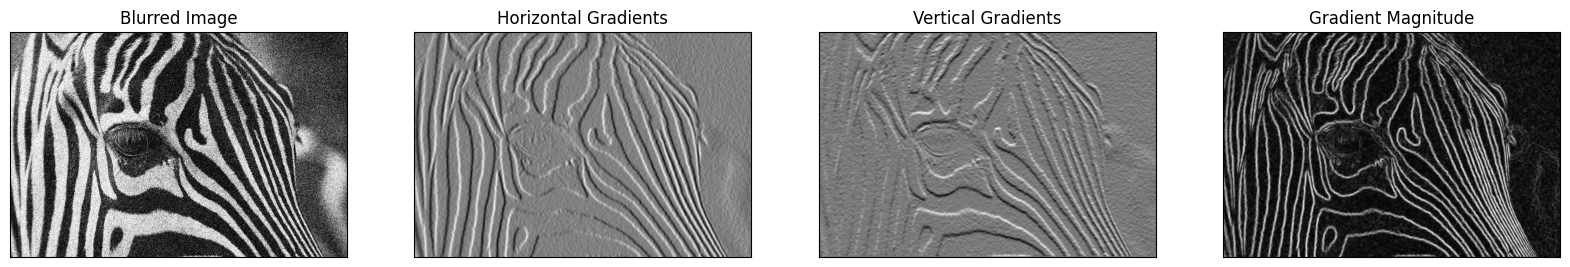

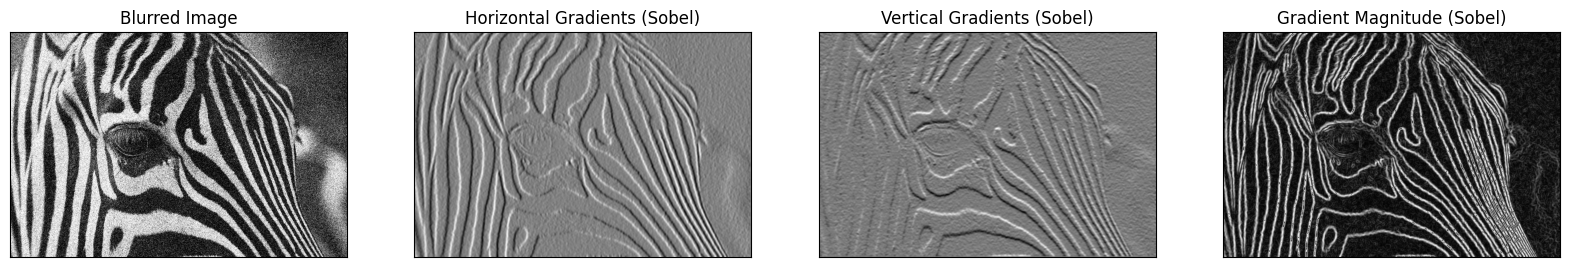

In [53]:
# Plot std gradient
hx = np.array([[-1, 0, 1]], dtype=np.float32)
plot_images_gradients (hx)

# Soebel 
sobelx = cv2.Sobel(img_gaussian_filter,cv2.CV_64F,1,0)
sobely = cv2.Sobel(img_gaussian_filter,cv2.CV_64F,0,1)
print("sobelx shape",sobelx.shape)

# Compute the magnitude of the Sobel-based gradients
sobelmag = np.sqrt(sobelx*sobelx + sobely*sobely)
print("Soebel magnitude:",sobelmag.shape)

fig = plt.figure(figsize = (20,10))

ax1 = fig.add_subplot(1,4,1)
ax1.imshow(img,cmap = 'gray')
ax1.set_title('Blurred Image'), ax1.set_xticks([]), ax1.set_yticks([])

ax4 = fig.add_subplot(1,4,2)
ax4.imshow(sobelx,cmap = 'gray')
ax4.set_title('Horizontal Gradients (Sobel)'), ax4.set_xticks([]), ax4.set_yticks([]);

ax5 = fig.add_subplot(1,4,3)
ax5.imshow(sobely,cmap = 'gray')
ax5.set_title('Vertical Gradients (Sobel)'), ax5.set_xticks([]), ax5.set_yticks([]);

ax6 = fig.add_subplot(1,4,4)
ax6.imshow(np.uint8(sobelmag),cmap = 'gray')
ax6.set_title('Gradient Magnitude (Sobel)'), ax6.set_xticks([]), ax6.set_yticks([]);

## Wrap-Up

In this exercise, we have explored a few filters that can be used to enhance an image, whether by removing noise or other unwanted detail or by emphasizing the presence of specific content, such as edges. 

These and other filters are an integral step to extracting information from images, whether it is to identify the location of the lane markings and, in turn, the geometry of the robot's lane, or detecting the location of pedestrians (i.e., duckies). 

These are just a few examples of filters that are commonly used for image processing. 

Operating on the same principle as filters designed for edge detection, corner detection filters look for locations in the image where there are rapid changes in intensity in both the $x$- and $y$-directions (e.g., like you might see at corners where two lines intersect). 

These and related filters are often employed to detect "interest points", salient points in the image that are used to identify correspondences between multiple images of the same scene (i.e., pixels that correspond to the same object in the world).

You can now move to the [visual servoing tutorial](../05-Visual-Servoing/visual_servoing_activity.ipynb).